In [408]:
import tensorflow as tf
import numpy as np
import gym
from gym import wrappers
import tflearn
import argparse
import pprint as pp
import numpy
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from matplotlib import path
import itertools
import scipy.misc

import copy
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline
def converting_scenario(scenario):
    snapshot = pd.DataFrame(columns=['entry_x','entry_y','middle_x','middle_y','exit_x','exit_y','res_x','res_y'])
    flight_info = {}
    flight_info['entry_x'] = scenario.sync_point_x_1
    flight_info['entry_y'] = scenario.sync_point_y_1
    flight_info['exit_x'] = scenario.exit_x_1
    flight_info['exit_y'] = scenario.exit_y_1
    
#     flight_info['middle_x'] = (scenario.sync_point_x_1 + scenario.exit_x_1)/2
#     flight_info['middle_y'] = (scenario.sync_point_y_1 + scenario.exit_y_1)/2
    flight_info['middle_x'] = scenario.middle_x_1
    flight_info['middle_y'] = scenario.middle_y_1
    flight_info['res_x'] = scenario.res_x
    flight_info['res_y'] = scenario.res_y
    
    snapshot = snapshot.append(flight_info, ignore_index=True)

    flight_info = {}
    flight_info['entry_x'] = scenario.sync_point_x_0
    flight_info['entry_y'] = scenario.sync_point_y_0
    flight_info['exit_x'] = scenario.exit_x_0
    flight_info['exit_y'] = scenario.exit_y_0
    flight_info['middle_x'] = (flight_info['entry_x'] + scenario.exit_x_0)/2
    flight_info['middle_y'] = (flight_info['entry_y'] + scenario.exit_y_0)/2
    
#     flight_info['middle_x'] =  scenario.middle_x_0
#     flight_info['middle_y'] =  scenario.middle_y_0
    snapshot = snapshot.append(flight_info, ignore_index=True)
    
    list_flights = pd.read_json(scenario.surrounding_flight)
    for i in range(len(list_flights)):
        flight_info = {}
        flight_info['entry_x'] = list_flights.iloc[i].sync_point_x 
        flight_info['entry_y'] = list_flights.iloc[i].sync_point_y
        flight_info['exit_x'] = list_flights.iloc[i].exit_x
        flight_info['exit_y'] = list_flights.iloc[i].exit_y
        flight_info['middle_x'] = (flight_info['entry_x'] + list_flights.iloc[i].exit_x)/2
        flight_info['middle_y'] = (flight_info['entry_y'] + list_flights.iloc[i].exit_y)/2
        snapshot = snapshot.append(flight_info, ignore_index=True)
        
    return snapshot

# Environment for learning Demo data
class flightOb():
    def __init__(self, Flight, ownship):
        self.enter_x = Flight.entry_x
        self.enter_y = Flight.entry_y
        self.exit_x = Flight.exit_x
        self.exit_y = Flight.exit_y
        self.middle_x = Flight.middle_x
        self.middle_y = Flight.middle_y
        self.enter_time = 0
        self.ownship = ownship
    
class simEnv():   
    ##################
    def __init__(self, size):
        self.size = size[0]
        self.maxnum = size[1]
        self.flights = []
        self.action_space = np.zeros(2)
        self.resol = []

#         self.info = 7
        self.optimal_features = [0, 0, 0]
        self.position_features = [0,0,0,0]
        self.closure_features = np.zeros((self.maxnum-1)*3)
#         self.traffic_features = np.zeros((self.maxnum-1)*2)
        self.num_feature = len(self.closure_features) + len(self.position_features) + len(self.optimal_features)
        self.observation_space = np.ones(self.num_feature ,dtype='uint8')
    
    def loadAirSpace(self,snapshot):
        objects = []
        
        for i in range(len(snapshot)):
            objects.append(flightOb(snapshot.iloc[i],i==0))
            
        for i in range(self.maxnum - len(snapshot)):
            objects.append(flightOb(snapshot.iloc[1],i==0))
            
        self.resol = snapshot.iloc[0][['res_x','res_y']]
        return objects
    
    def render(self):
        plt.figure()
        Flight = self.flights[0]
        plt.plot([Flight.enter_x,Flight.middle_x,Flight.exit_x], [Flight.enter_y,Flight.middle_y,Flight.exit_y],'rx--')
        plt.scatter(Flight.enter_x,Flight.enter_y,c='r')
        
        Flight = self.flights[1]
        plt.plot([Flight.enter_x,Flight.middle_x,Flight.exit_x], [Flight.enter_y,Flight.middle_y,Flight.exit_y],'bx-.')
        plt.scatter(Flight.enter_x,Flight.enter_y,c='b')
        
        for i in range(2,len(self.flights)):
            Flight = self.flights[i]
            plt.plot([Flight.enter_x,Flight.middle_x,Flight.exit_x], [Flight.enter_y,Flight.middle_y,Flight.exit_y],'gx-.')
            plt.scatter(Flight.enter_x,Flight.enter_y,c='g')
            
        plt.scatter(self.resol[0],self.resol[1],c='b')
        
        plt.xlim(0, 800)
        plt.ylim(0, 800)
        plt.show()
        return 1

    def get_state(self):
        v = [self.flights[0].middle_x - self.resol[0], self.flights[0].middle_y - self.resol[1]]
        self.optimal_features = [np.linalg.norm(v),v[0],v[1]]
        position = [self.flights[0].middle_x-self.flights[0].enter_x, self.flights[0].middle_y-self.flights[0].enter_y]
        self.position_features = [np.linalg.norm(position),position[0],position[1], self.UL]
        
        state = self.closure_features + self.position_features + self.optimal_features
        return state
    
    def reset(self, snapshot, UL = 0):
        if UL == 0:
            per = 0
        elif UL == 1:
            per = 2
        elif UL == 2:
            per = 5
        else:
            per = 10
            
        self.UL = per
        self.flights = self.loadAirSpace(snapshot)
        self.check_state(self.flights[0]) 
        state = self.get_state() 
        return state
    
    def check_state(self,Ownship, init = False):
#         Ownship = self.flights[0]
        CFeature = []
        penalty = 0
        for i in range(1,len(self.flights)):
            Intruder = self.flights[i]  
            #[True, cpaClosure, cpaPoint1, cpaPoint2,v]
            cf = self.conflict_dectector(Ownship, Intruder, 0.8888, 0.8888)
            
            CFeature.append(cf[1])
            CFeature.extend(cf[4])
            
            cpaClosure = cf[1]
            if cpaClosure <1:            
                penalty = min(penalty,(np.exp((cpaClosure-1))-1)*100)
            
#             if init & (i == 1):
#                 self.resol = cf[2]
        
#         for i in range(self.maxnum - len(self.flights)):
#             CFeature.extend([10,800,800])

        self.closure_features = CFeature        
        return penalty
    
    def cpa_calculator(self,begin1x, begin1y, end1x, end1y, begin2x, begin2y, end2x, end2y, speed1, speed2):
        # Min CPA allowed
        cpaThreshold = 40
        # related points
        begin1 = np.array([begin1x, begin1y])
        end1 = np.array([end1x, end1y])
        begin2 = np.array([begin2x, begin2y])
        end2 = np.array([end2x, end2y])  
        # segments length
        d1 = np.linalg.norm(end1 - begin1)
        d2 = np.linalg.norm(end2 - begin2)
        
        default = np.linalg.norm(begin1 - begin2)
        cpaStatus = [False, default,begin1, begin2,begin1-begin2]

        if (d1 == 0) | (d2 == 0):
            if default < cpaThreshold:
                cpaStatus[0] = True
                cpaStatus[1] = cpaStatus[1]/cpaThreshold
            return cpaStatus
            
        # directional unit velocity vectors
        v1 = np.array(end1 - begin1) / d1
        v2 = np.array(end2 - begin2) / d2
        # initial closure vector and relative velocity vector
        w0 = np.array(begin1 - begin2)
        dv = v1 * speed1 - v2 * speed2
        time2cpa = - (np.dot(w0, dv)) / (np.linalg.norm(dv)**2)
        travelledDist1 = speed1 * time2cpa
        travelledDist2 = speed2 * time2cpa
        
        if time2cpa >= 0 and travelledDist1 <= d1 and travelledDist2 <= d2 :            
            cpaPoint1 = begin1 + v1 * travelledDist1 
            cpaPoint2 = begin2 + v2 * travelledDist2
            cpaClosure = np.linalg.norm(cpaPoint1 - cpaPoint2)
            v = cpaPoint1 - cpaPoint2
            if cpaClosure < cpaThreshold :
                cpaStatus = [True, cpaClosure, cpaPoint1, cpaPoint2,v]
            else:
                cpaStatus = [False, cpaClosure, cpaPoint1, cpaPoint2,v]
        
        cpaStatus[1]  = cpaStatus[1]/cpaThreshold
        return cpaStatus

    def conflict_dectector(self,ownship, intruder, speed1, speed2) :
        conflict = False
        # entry and exit positions of intruder
        intruder_entry = np.array([intruder.enter_x, intruder.enter_y])
        intruder_exit = np.array([intruder.exit_x, intruder.exit_y])
        intruder_path_length = np.linalg.norm(intruder_exit - intruder_entry)    
        # find direction of intruder
        intruder_dir = (intruder_exit - intruder_entry) / intruder_path_length
        # sync_point is position of intruder at the moment ownship enters the sector
        # sync_point = enter_point + offset in the moving direction
        intruder_entry_offset = ownship.enter_time * speed2 
        sync_point = intruder_entry + intruder_dir * intruder_entry_offset                               

        # now check: ownship1 vs intruder
        # begin point of intruder must be sync_point

        hasCpa = self.cpa_calculator(ownship.enter_x, ownship.enter_y, ownship.middle_x, ownship.middle_y, 
                                    sync_point[0], sync_point[1], intruder.exit_x, intruder.exit_y,
                                    speed1, speed2)
        hasCpa1 = [False, 1000]
        if hasCpa[0] :
            return hasCpa
        else :
            # entry, middle, and exit positions of intruder
            ownship_entry = np.array([ownship.enter_x, ownship.enter_y])
            ownship_middle = np.array([ownship.middle_x, ownship.middle_y])
            ownship_exit = np.array([ownship.exit_x, ownship.exit_y])
            ownship_first_length = np.linalg.norm(ownship_middle - ownship_entry)
            intruder_second_offset = intruder_entry_offset + ownship_first_length
            if intruder_second_offset <= intruder_path_length :
                intruder_begin = intruder_entry + intruder_dir * intruder_second_offset
                # checking ownship2 vs intruder:
                hasCpa1 = self.cpa_calculator(ownship.middle_x, ownship.middle_y, ownship.exit_x, ownship.exit_y, 
                                            intruder_begin[0], intruder_begin[1], intruder.exit_x, intruder.exit_y,
                                            speed1, speed2)
                if hasCpa1[0] :
                    return hasCpa1
        if hasCpa[1] > hasCpa1[1]:
            hasCpa = hasCpa1[:]
        return hasCpa
    
def train_agent(df_train, size, max_num):
    env = simEnv([size,max_num])
    X = []
    Y = []

    for index in range(0,len(df_train)):
        snapshot = converting_scenario(df_train.iloc[index])
        state = env.reset(snapshot[:max_num])
        X.append(state)
        Y.append(env.resol.values)
        
    regr = RandomForestRegressor(max_depth=10, random_state=1, n_estimators=100)
    regr.fit(X, Y) 
    return regr
    
def predict_agent(model, scenario, size, max_num):
    env = simEnv([size,max_num])
    X = []
    snapshot = converting_scenario(scenario)
    state = env.reset(snapshot[:max_num])
    X.append(state)
    
    Y= model.predict(X)
    return Y

def score(F_Res, Y):
    list_score=[]
    for i in range(len(F_Res)):
        list_score.append(np.linalg.norm(np.array(F_Res[i])-Y))
        
    return np.array(list_score)

In [409]:
df = pd.read_csv('100_5.csv')
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_ = df.sample(frac=0.8,random_state=200)
df_train = df_train.append(df_)
df_test = df_test.append(df.drop(df_.index))

In [410]:
model = train_agent(df_train, 400, max_num)

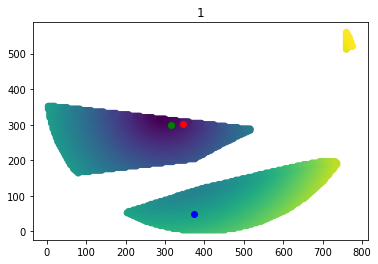

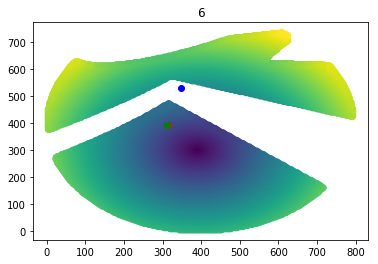

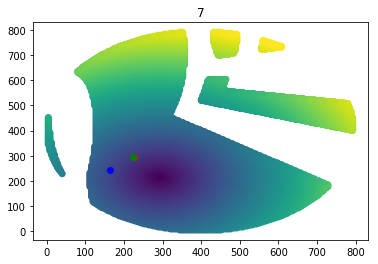

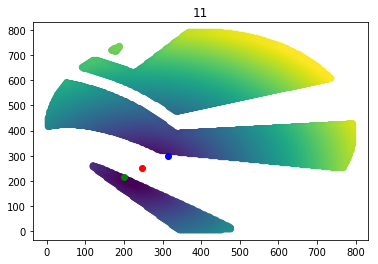

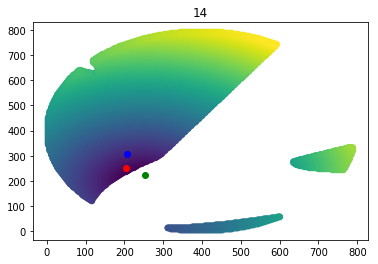

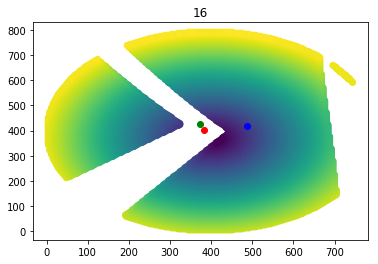

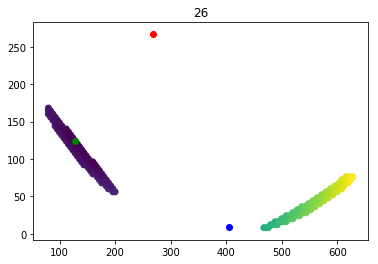

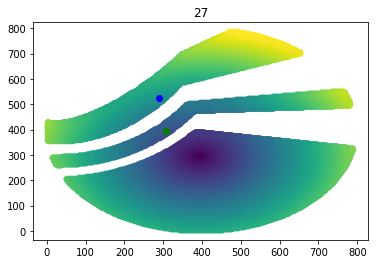

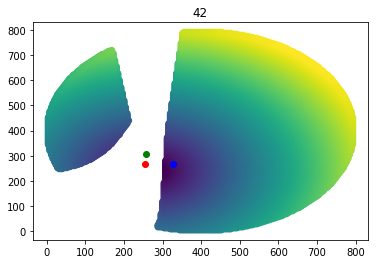

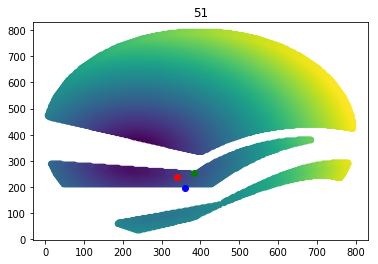

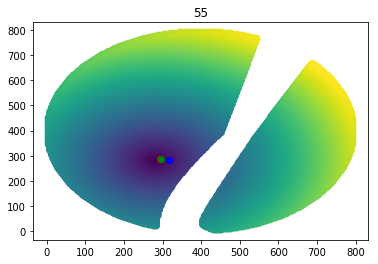

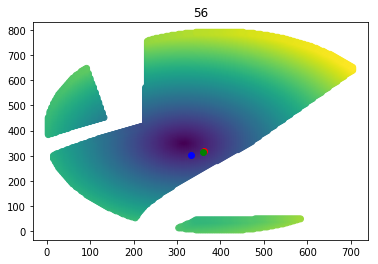

IndexError: list index out of range

In [412]:
for i in range(len(df_test)):
    Y = predict_agent(model, df_test.iloc[i], 400, max_num)
    F_Res = np.array(All_Map[df_test.index[i]])
    l_score = score(F_Res, Y) 
    Pred_P = F_Res[np.argmin(l_score)]
    plt.scatter(F_Res[:,0],F_Res[:,1],c=l_score)
    plt.scatter(Y[0][0],Y[0][1], c='r')
    plt.scatter(Y_test[i][0],Y_test[i][1], c='b')
    plt.scatter(Pred_P[0],Pred_P[1], c='g')
    plt.title(df_test.index[i])
    plt.show()

In [397]:
df = pd.read_csv('map.csv',delimiter=',', header=0)

All_Map = []
for step in range(len(df)//200):
    F_Res = []

    for i in range(200):
        for j in range(step*200, (step+1)*200):
            if df[str(i)][j] == 0:
                F_Res.append([i*4,(j-step*200)*4])
    All_Map.append(F_Res)